In [1]:
%load_ext autoreload
%autoreload 2

import h5py
import curie as ci
import numpy as np
import mfdf
import healpy
import imageio
from tqdm.notebook import tqdm
import os

from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from CoordinateConversion import LatLon2XY
import pickle

In [4]:
# Aug 2022 flights
true_location = np.array(
    [-43.727623, -15.6186695]
)  # for Aug 2022 flights, taken from the triple dip measurement as the actual source hover bag is corrupt

h5_file = "/home/emil/temp/rfsdata/2022_08_12_10_21_39/data.bag.h5"  # do square at 10 m and hower at source position
h5_file = "/home/emil/temp/rfsdata/2022_08_12_10_36_11/data.bag.h5"  # square@13m with minor hickups (probably hover)
h5_file = "/home/emil/temp/rfsdata/2022_08_12_12_42_38/data.bag.h5"  # 2 cross dips @7m, 1X m square, initial misjudgemnt on src position
h5_file = "/home/emil/temp/rfsdata/2022_08_12_13_07_11/data.bag.h5"  # square@15 m, no src reaction behaviour
h5_file = "/home/emil/temp/rfsdata/2022_08_12_13_14_13/data.bag.h5"  # do square, no source detected (rosbridge was down)
h5_file = "/home/emil/temp/rfsdata/2022_08_12_13_22_43/data.bag.h5"  # just noise at start position, no takeoff
h5_file = "/home/emil/temp/rfsdata/2022_08_12_13_24_47/data_repaired.bag.h5"  # square, no source detected (rosbridge was down)
h5_file = "/home/emil/temp/rfsdata/2022_08_12_13_33_21/data.bag.h5"  # two cross dips during the square
h5_file = "/home/emil/temp/rfsdata/2022_08_12_13_43_24/data_repaired.bag.h5"  # 2 cross dips @7m, 13 m square
h5_file = "/home/emil/temp/rfsdata/2022_08_12_14_02_57/data.bag.h5"  # search square reverse (clockwise), 1 cross dip@7m
h5_file = "/home/emil/temp/rfsdata/2022_08_12_14_21_56/data_repaired.bag.h5"  # not sure what's going on
h5_file = "/home/emil/temp/rfsdata/2022_08_12_14_10_14/data.bag.h5"  # search square reverse (clockwise), 2 cross dips@7m

h5_file = (
    "2022_08_12_10_36_11/data.bag.h5"  # square@13m with minor hickups (probably hover)
)
h5_file = "2022_08_12_12_42_38/data.bag.h5"  # 2 cross dips @7m, 1X m square, initial misjudgemnt on src position
h5_file = "2022_08_12_13_07_11/data.bag.h5"  # square@15 m, no src reaction behaviour
h5_file = "2022_08_12_13_14_13/data.bag.h5"  # do square, no source detected (rosbridge was down)
h5_file = "2022_08_12_13_22_43/data.bag.h5"  # just noise at start position, no takeoff
h5_file = "2022_08_12_13_24_47/data_repaired.bag.h5"  # square, no source detected (rosbridge was down)
h5_file = "2022_08_12_14_21_56/data_repaired.bag.h5"  # not sure what's going on
h5_file = "2022_08_12_14_10_14/data.bag.h5"  # search square reverse (clockwise), 2 cross dips@7m
h5_file = "2022_08_12_14_02_57/data.bag.h5"  # search square reverse (clockwise), 1 cross dip@7m
h5_file = "2022_08_12_13_33_21/data.bag.h5"  # two cross dips during the square
h5_file = "2022_08_12_13_43_24/data_repaired.bag.h5"  # 3 cross dips @7m, 13 m square


h5_file = (
    "2022_08_12_10_21_39/data.bag.h5"  # do square at 10 m and hower at source position
)
h5_file = "2022_08_12_13_43_24/data_repaired.bag.h5"  # 3 cross dips @7m, 13 m square

h5_file = "2022_08_12_13_33_21/data.bag.h5"  # two cross dips during the square

In [3]:
# Feb 2023 Flights
# TODO what is the true location this time?
true_location = np.array(
    [-43.727623, -15.6186695]
)  # for Aug 2022 flights, taken from the triple dip measurement as the actual source hover bag is corrupt

h5_file = "2023-02-16_rfs_w_Marco_Celine/2023_02_16_17_20_14/data.bag.h5"  # hover manually to first and second source position
files = []
h5_file = "2023-02-16_rfs_w_Marco_Celine/2023_02_16_17_10_15/data.bag.h5"  # two dips, then back to first corner
files.append(h5_file)
h5_file = "2023-02-16_rfs_w_Marco_Celine/2023_02_16_17_03_03/data.bag.h5"  # one dip, 1st source location
files.append(h5_file)
h5_file = "2023-02-16_rfs_w_Marco_Celine/2023_02_16_17_34_38/data.bag.h5"  # three dips then RTH because time limit reached
files.append(h5_file)
h5_file = "2023-02-16_rfs_w_Marco_Celine/2023_02_16_16_38_45/data.bag.h5"  # Two dips
files.append(h5_file)
h5_file = "2023-02-16_rfs_w_Marco_Celine/2023_02_16_17_26_15/data.bag.h5"  # First dip super early
files.append(h5_file)
h5_file = "2023-02-16_rfs_w_Marco_Celine/2023_02_16_13_39_33/data.bag.h5"  # 870 sec, flying towards us because of source next to our table?

h5_file = (
    "2023-02-16_rfs_w_Marco_Celine/2023_02_16_13_30_57/data.bag.h5"  # Unable to open
)
h5_file = (
    "2023-02-16_rfs_w_Marco_Celine/2023_02_16_13_23_06/data.bag.h5"  # Unable to open
)
h5_file = (
    "2023-02-16_rfs_w_Marco_Celine/2023_02_14_13_36_52/data.bag.h5"  # Unable to open
)
h5_file = (
    "2023-02-16_rfs_w_Marco_Celine/2023_02_16_15_09_15/data.bag.h5"  # unable to open
)
h5_file = "2023-02-16_rfs_w_Marco_Celine/2023_02_13_17_13_42/data_fixed.bag.h5"  # Unable to open
h5_file = "2023-02-16_rfs_w_Marco_Celine/2023_02_14_14_02_55/data_fixed.bag.h5"  # Unable to open
h5_file = "2023-02-16_rfs_w_Marco_Celine/2023_02_16_15_11_32/data_fixed.bag.h5"  # Unable to open

h5_file = "2023-02-16_rfs_w_Marco_Celine/2023_02_16_16_34_46/data.bag.h5"  # 122 sec, take off then aborted?
h5_file = "2023-02-16_rfs_w_Marco_Celine/2023_02_16_15_37_51/data.bag.h5"  # 49 sec, goes up 1 meter?
h5_file = "2023-02-16_rfs_w_Marco_Celine/2023_02_16_14_41_21/data.bag.h5"  # 800s without taking off
h5_file = "2023-02-16_rfs_w_Marco_Celine/2023_02_16_13_31_40/data_fixed.bag.h5"  # 105s without taking off
h5_file = "2023-02-16_rfs_w_Marco_Celine/2023_02_16_15_32_37/data_fixed.bag.h5"  # 24s without taking off
h5_file = (
    "2023-02-16_rfs_w_Marco_Celine/2023_02_16_14_02_01/data.bag.h5"  # Not taking off
)
h5_file = "2023-02-16_rfs_w_Marco_Celine/2023_02_16_14_20_12/data.bag.h5"  # 999.99sec at start position
h5_file = "2023-02-16_rfs_w_Marco_Celine/2023_02_16_14_07_56/data.bag.h5"  # 680 s without taking off
h5_file = "2023-02-16_rfs_w_Marco_Celine/2023_02_16_16_16_07/data.bag.h5"  # 880s, little circle around takeoff? Maybe just gps drift
h5_file = "2023-02-16_rfs_w_Marco_Celine/2023_02_16_15_28_30/data.bag.h5"  # 100s without taking off
h5_file = "2023-02-16_rfs_w_Marco_Celine/2023_02_16_16_31_25/data.bag.h5"  # 77s without taking off
h5_file = "2023-02-16_rfs_w_Marco_Celine/2023_02_16_17_09_11/data.bag.h5"  # 20s without taking off
h5_file = "2023-02-16_rfs_w_Marco_Celine/2023_02_16_13_54_46/data.bag.h5"  # 77s without taking off


h5_file = "2023-02-16_rfs_w_Marco_Celine/2023_02_16_17_10_15/data.bag.h5"  # two dips, then back to first corner
h5_file = "2022_08_12_13_33_21/data.bag.h5"  # two cross dips during the square
files.append(h5_file)
sigma_source_threshold = 50

In [9]:
# July 2023 flights
h5_files = []
h5_file = "/home/emil/data/RFS/2023_07_13_overshoot_chase_and_x-dips/2023_07_13_21_24_58/data.bag.h5"  # no rxn to source.  sigma paramenter got to ~55 on N pass and 45 on W pass (which is about 3m standoff)
h5_files.append(h5_file)
h5_file = "/home/emil/data/RFS/2023_07_13_overshoot_chase_and_x-dips/2023_07_13_19_51_00/data.bag.h5"  # good x1

h5_files.append(h5_file)
h5_file = "/home/emil/data/RFS/2023_07_13_overshoot_chase_and_x-dips/2023_07_13_23_33_21/data.bag.h5"  # odd, deviated and flew straight to source then got stuck
h5_files.append(h5_file)
h5_file = "/home/emil/data/RFS/2023_07_13_overshoot_chase_and_x-dips/2023_07_14_00_18_57/data.bag.h5"  # good, x1
h5_files.append(h5_file)
h5_file = "/home/emil/data/RFS/2023_07_13_overshoot_chase_and_x-dips/2023_07_13_20_08_30/data.bag.h5"  # odd - should look at
h5_files.append(h5_file)
h5_file = "/home/emil/data/RFS/2023_07_13_overshoot_chase_and_x-dips/2023_07_13_22_53_36/data.bag.h5"  # went by source, then got stuck again.  looks like it localized one source then was too close to '2nd source', but there's only 1 out there.
h5_files.append(h5_file)
h5_file = "/home/emil/data/RFS/2023_07_13_overshoot_chase_and_x-dips/2023_07_14_00_25_08/data.bag.h5"  # early deteection, but good
h5_files.append(h5_file)
h5_file = "/home/emil/data/RFS/2023_07_13_overshoot_chase_and_x-dips/2023_07_13_20_15_51/data.bag.h5"  # good x2
h5_files.append(h5_file)
h5_file = "/home/emil/data/RFS/2023_07_13_overshoot_chase_and_x-dips/2023_07_13_22_23_43/data.bag.h5"  # reacted to source, but seems to have gotten stuck after first flying away, then flying straight to it.
h5_files.append(h5_file)
h5_file = "/home/emil/data/RFS/2023_07_13_overshoot_chase_and_x-dips/2023_07_13_19_08_46/data.bag.h5"  # found source a little early and did 2 x's.  worked well
h5_files.append(h5_file)
h5_file = "/home/emil/data/RFS/2023_07_13_overshoot_chase_and_x-dips/2023_07_13_23_13_46/data.bag.h5"  # quick localization, moved grid 6m further west and lengthened stable source time to 6s instead of 4s.  also changed localization stability parameter from <2m to 3m (which includes adjacent and diagnol).  BQ thinks we should keep this small
h5_files.append(h5_file)
h5_file = "/home/emil/data/RFS/2023_07_13_overshoot_chase_and_x-dips/2023_07_13_23_21_09/data.bag.h5"  # good
h5_files.append(h5_file)
h5_file = "/home/emil/data/RFS/2023_07_13_overshoot_chase_and_x-dips/2023_07_13_20_03_27/data.bag.h5"  # good x1
h5_files.append(h5_file)
h5_file = "/home/emil/data/RFS/2023_07_13_overshoot_chase_and_x-dips/2023_07_14_00_05_04/data.bag.h5"  # odd, it first localized too far E, then saw it again after the NW wp briefly
h5_files.append(h5_file)
h5_file = "/home/emil/data/RFS/2023_07_13_overshoot_chase_and_x-dips/2023_07_13_23_45_38/data.bag.h5"  # flew towards-ish source then did an x W of it before continuing survey.  good localization (I'm guessing)
h5_files.append(h5_file)
h5_file = "/home/emil/data/RFS/2023_07_13_overshoot_chase_and_x-dips/2023_07_13_21_49_48/data.bag.h5"  # look at
h5_files.append(h5_file)
h5_file = "/home/emil/data/RFS/2023_07_13_overshoot_chase_and_x-dips/2023_07_13_21_57_10/data.bag.h5"  # look at
h5_files.append(h5_file)
h5_file = "/home/emil/data/RFS/2023_07_13_overshoot_chase_and_x-dips/2023_07_13_23_58_48/data.bag.h5"  # too? good
h5_files.append(h5_file)
h5_file = "/home/emil/data/RFS/2023_07_13_overshoot_chase_and_x-dips/2023_07_13_19_56_58/data.bag.h5"  # good x2
h5_files.append(h5_file)
h5_file = "/home/emil/data/RFS/2023_07_13_overshoot_chase_and_x-dips/2023_07_13_22_47_02/data.bag.h5"  # good
h5_files.append(h5_file)

In [51]:
# April 2023 Flights with Andrew, various grids
true_location_latlon = np.array(
    [37.9159454, -122.3366369]
)  # source location by a white plastic pole April-May 2023
true_location = None
files = []
h5_file = "2023-04-12-Andrew/2023_04_12_14_59_32-20230521T070640Z-001/2023_04_12_14_59_32/data.bag.h5"  # big grid to ts 750, then squares
files.append(h5_file)
# h5_file = '2023-04-12-Andrew/2023_04_12_11_43_17-20230521T070705Z-001/2023_04_12_11_43_17/data.bag.h5' # big S-shape
# files.append(h5_file)
# h5_file = '2023-04-12-Andrew/2023_04_12_14_21_14-20230521T070647Z-001/2023_04_12_14_21_14/data.bag.h5' # some long tracks, some spirals
# files.append(h5_file)
# h5_file = '2023-04-12-Andrew/2023_04_12_12_40_01-20230521T070655Z-001/2023_04_12_12_40_01/data.bag.h5' # spirals
# files.append(h5_file)

In [81]:
# simulation files
true_location = np.array(
    [-43.727623, -15.6186695]
)  # for Aug 2022 flights, taken from the triple dip measurement as the actual source hover bag is corrupt
files = []
h5_file = "simdata/_2023-05-22-21-06-50.bag.h5"  # square with cross dips, HIGH ACTIVITY
# files.append(h5_file)
# h5_file = 'simdata/10iter_200uci/_2023-05-23-03-31-37.bag.h5' # 10 iter, 200uCi limit
# h5_file = 'simdata/no_det_pos/_2023-05-23-04-47-17.bag.h5' # 10 iter, det_pos false
# # h5_file = 'simdata/1mci_30pad_0.5vox/_2023-05-23-06-39-25.bag.h5' # wonky not good, 1 mCi source, 10 iter, 0.5 m voxels, 30 pad
# h5_file = 'simdata/thresh_sigma_30.bag.h5'
# h5_file = 'simdata/1mCi_dip_20iter.bag.h5' #just a square, source threshold never crossed
# sigma_source_threshold = 30

# h5_file = 'simdata/_2023-05-24-12-08-58.bag.h5' #overshooting
h5_file = "simdata/_2023-05-24-12-22-47.bag.h5"  # overshooting looks better
# h5_file = 'simdata/_2023-05-24-13-25-12.bag.h5' #chase at height
# h5_file = 'simdata/_2023-05-24-13-40-57.bag.h5' #chase at height2


sigma_source_threshold = 35

files.append(h5_file)

In [51]:
data_folder_path = "/home/emil/data/RFS/2022_08_12_RFS_Autonomy_MiniLAMP"
h5_file_abs = os.path.join(data_folder_path, h5_file)
files = [h5_file_abs]
with h5py.File(h5_file_abs, "r") as f:
    print(f.keys())

<KeysViewHDF5 ['an_device', 'count_vs_time', 'imu_ros', 'interaction_data', 'mavros', 'rad', 'sensor_diagnostics']>


In [50]:
import trajan as tr


def h5_to_latlon(h5_file):
    with h5py.File(h5_file, "r") as f:
        lat = f["mavros/global_position/global/latitude"][()]
        lon = f["mavros/global_position/global/longitude"][()]
        alt = f["mavros/global_position/global/altitude"][()]
        return lat, lon, alt


def h5_to_traj(h5_file):
    with h5py.File(h5_file, "r") as f:
        x = f["mavros/global_position/local/pose.pose.position.x"][()]
        y = f["mavros/global_position/local/pose.pose.position.y"][()]
        z = f["mavros/global_position/local/pose.pose.position.z"][()]
        qx = f["mavros/global_position/local/pose.pose.orientation.x"][()]
        qy = f["mavros/global_position/local/pose.pose.orientation.y"][()]
        qz = f["mavros/global_position/local/pose.pose.orientation.z"][()]
        qw = f["mavros/global_position/local/pose.pose.orientation.w"][()]
        times = f["mavros/global_position/local/header.stamp"][()]
        rad = ci.Listmode.read(f["/rad"])
    traj = tr.Trajectory(
        translations=tr.Translations(x, y, z),
        rotations=tr.Rotations.from_quaternions(qw, qx, qy, qz),
        ts=times,
        header=tr.Header(),
    )
    return traj, rad

In [7]:
# some parameters used throughout the notebook
padding = 15

# create a converter between the local and global frame
# use latlon2xy.getxy or getlatlon

In [52]:
traj, rad = h5_to_traj(h5_file_abs)
traj

Trajectory:
    Header:
        timestamp: None [DISABLED]
        frame_id: None
        child_frame_id: None
    num nodes: 1497
    x: range=(-55.406, 0.580)
    y: range=(-29.069, 1.199)
    z: range=(-0.307, 19.633)
    time: ts_range=(1660336411.026, 1660336733.054), duration=322.028 sec
    ts_edges: undefined

In [53]:
traj.duration

322.0276165008545

In [54]:
lat, lon, alt = h5_to_latlon(h5_file_abs)
lat = lat[1:]
lon = lon[1:]
alt = alt[1:]
latlon2xy = LatLon2XY(lat[0], lon[0], trajcut.px[0], trajcut.py[0])
if true_location is None:
    true_location = latlon2xy.get_xy(*true_location_latlon)

(0.0, 1000.0)

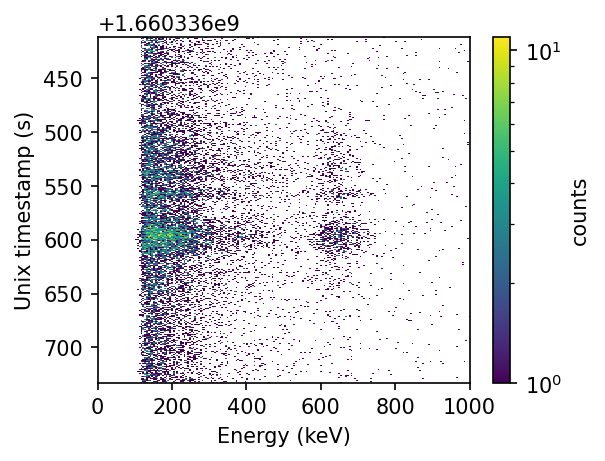

In [55]:
fig, ax = plt.subplots(dpi=150, figsize=(4, 3))
rad.cut(ranges={"timestamp_det": [traj.ts[0], traj.ts[0] + 1000]}).plot_waterfall(
    norm=LogNorm(), ax=ax
)
ax.set_xlim([0, 1000])

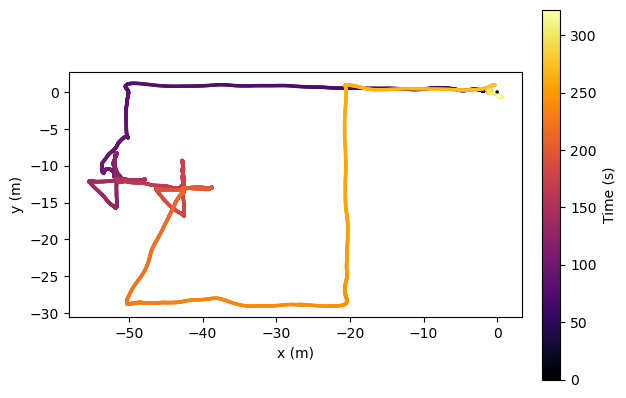

In [56]:
trajcut = traj.cut(
    ranges={
        "ts": [traj.ts[0], traj.ts[0] + 750],
        "px": [-1000, 1000],
        "py": [-1000, 1000],
    }
)
if type(trajcut) == tr.trajectory.Trajectories:
    trajcut = trajcut[1]
traj_resample = trajcut.resample(0.05)
traj_resample.plot(
    axes_length=3,
    draw_colorbar=True,
    path_cmap="inferno",
    path_lines=False,
    path_data=traj_resample.ts - traj_resample.ts[0],
    plot_axes=False,
    colorbar_kwargs={"label": "Time (s)"},
)

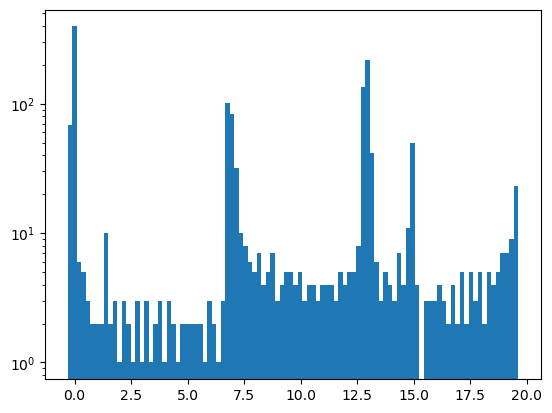

In [57]:
plt.hist(traj.cut(ranges={"px": [-1e5, 1e5]}).pz, bins=100)
plt.yscale("log")

In [58]:
import radkit_lamp as rkl

system = "minilamp"
recon_config = mfdf.ReconConfigurator(config=rkl.get_recon_config(system))

recon_config.set_param("E", 662.0)
recon_config.set_param("path_padding", 20)
recon_config.set_param("voxel_size", 0.5)

sys_config = mfdf.SystemConfigurator(config_file=rkl.get_system_config(system))

In [59]:
recon_config.get_param("path_padding")

20

In [60]:
recon_config.get_param("voxel_size")

0.5

In [61]:
def create_world(trajectory):
    # Create dense ground plane
    meta = tr.VoxelGridMeta.from_trajectory(
        trajectory,
        delta=recon_config.get_param("voxel_size"),
        pad=recon_config.get_param(
            "path_padding"
        ),  # 20#job.dynamic_params["trajectory_pad"],
    )
    # Assume the trajectory starts on the ground
    world = tr.VoxelGrid(meta=meta, dense=True).cut(
        ranges={
            "z": (
                traj.pz[0] - 0.5 - 1e-6,
                traj.pz[0] - 0.5 + 1e-6,
            )
        }
    )
    return world


world = create_world(trajcut)

In [62]:
meas = mfdf.Measurement(rad, trajcut, world, sys_config)
meas.write(f"{h5_file_abs}.recon.h5", overwrite_existing=True)

In [63]:
resp = sys_config.get_response(mode="gpsl")
fig, ax = plt.subplots(dpi=150, figsize=(4, 3))
ax.remove()
healpy.mollview(resp.resp_matrix[7][0], title="", fig=fig)
fig, ax = plt.subplots(dpi=150, figsize=(4, 3))
ax.remove()
healpy.mollview(resp.resp_matrix[7][-1], title="", fig=fig)

In [64]:
meas_orig = meas.copy()

In [65]:
def fix_header(meas):
    meas.traj.header.child_frame_id = "base_link"
    meas.traj.header.frame_id = "map"
    meas.transform_traj_to_det_frame()

In [66]:
fix_header(meas)

In [67]:
# 2D projection plot
plt.figure(figsize=(12, 8))
xmax, ymax, zmax = meas.traj.get_max_xyz()
xmin, ymin, zmax = meas.traj.get_min_xyz()
meas.plot(
    plane="xy",
    xmin=xmin - 10,
    xmax=xmax + 10,
    ymin=ymin - 10,
    ymax=ymax + 10,
    zmin=None,
    zmax=None,
    plot_traj=True,
    traj_colorize_by="counts",
    traj_kwargs={
        "path_cmap": "Reds",
        "path_lines": False,
        "draw_colorbar": True,
        "s": 25,
    },
)

plt.show()

In [68]:
# A Status object exists to handle logging with optional callbacks (iterations, interrupts), useful for ROS packages
# this gets created and used in the Reconstruction object
status = mfdf.tools.status.Status(name="mfdf recon", quiet=True)

In [69]:
# the Reconstruction class takes in a Measurement and a ReconConfigurator
recon = mfdf.Reconstruction(measurement=meas, config=recon_config, status=status)

In [70]:
# Gridded Point Source Likelihood (GPSL) - effectively many single-voxel MLEM recons
image_gpsl, bkgs_gpsl = recon.compute_gpsl()
# image_gpsl, bkgs_gpsl = recon.compute_occlusion()

In [71]:
# meas_copy = meas.copy()
# meas_copy.cut_time(
#     t=(meas.traj.ts[0] + 10, meas.traj.ts[0]+75)
# )

# world = create_world(meas_copy.traj)
# meas_copy.world = world
# recon = mfdf.Reconstruction(
#     measurement=meas_copy,
#     config=recon_config,
#     status=status
# )
# image_gpsl, bkgs_gpsl = recon.compute_gpsl()

In [72]:
# there is also a compute_forward_projection method defined to forward project an image back into measurement space
fp_gpsl, loss_gpsl = recon.compute_forward_projection(
    image=image_gpsl,  # the image to project
    bkgs=bkgs_gpsl,  # any backgrounds to include in the projection
    return_loss=True,  # whether to compute and return the loss to measured data
    return_as_binmode=False,  # whether the returned projection is a ci.Tensor or ci.Binmode
)

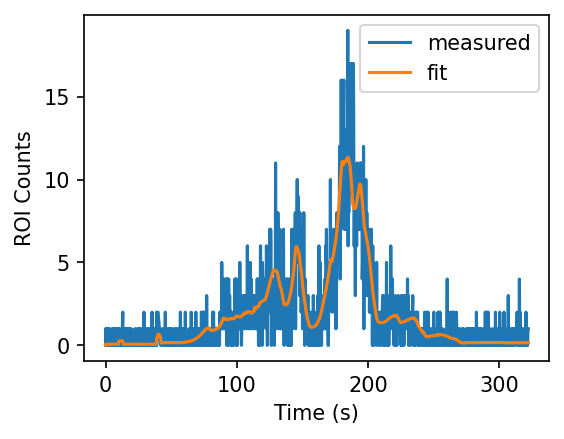

In [73]:
# the forward projection is of shape num poses by num detectors
# print(f"Shape: {fp_gpsl.data.shape}")

# useful to sum and plot over poses to see the fit
# can also overlay it on the measured data
plt.figure(figsize=(4, 3), dpi=150)
plt.plot(
    recon.meas.traj.ts - recon.meas.traj.ts[0],
    recon.construct_rad_tensor("gpsl").data.sum(1),
    label="measured",
)
plt.plot(recon.meas.traj.ts - recon.meas.traj.ts[0], fp_gpsl.data.sum(1), label="fit")
plt.xlabel("Time (s)")
plt.ylabel("ROI Counts")
plt.legend()
plt.show()

In [74]:
image_gpsl.nll

array([3454.0962, 3452.1343, 3450.208 , ..., 4021.3884, 4021.4504,
       4021.4895], dtype=float32)

In [75]:
def true_voxel_zscore(image_gpsl):
    voxel_positions = np.array([image_gpsl.x, image_gpsl.y])
    distances_to_true = np.linalg.norm(
        voxel_positions.T - np.atleast_2d(true_location), axis=1
    )
    if np.min(distances_to_true) > 20:
        return 5
    else:
        idx_true_voxel = np.argmin(distances_to_true)
        return image_gpsl.zscores[idx_true_voxel]

In [76]:
# we can easily plot a projection of the image on our measurement
# plt.figure(figsize=(11,7))

# config for submitting SORMA summary
xmin, ymin, zmin = -64, -35, None
xmax, ymax, zmax = 9, 5, None
vmin, vmax = 0, 175
pad = 0.14
figsize = (7, 3.1)

# long lines
xmin, ymin, zmin = meas.traj.get_min_xyz()
xmax, ymax, zmax = meas.traj.get_max_xyz()
xmin = xmin - padding
xmax = xmax + padding
ymin = ymin - padding
ymax = ymax + padding
vmin, vmax = None, None
pad = 0.14
figsize = (7, 3.1)
# fig, ax = plt.subplots(figsize=(5, 4), dpi=250)
plt.figure(figsize=figsize, dpi=250)


image_gpsl.plot(
    prop="zscores",  # which property of the voxelgrid to plot
    plane="xy",  # which plane for projection
    reduction="min",  # how to reduce on the projection
    mask_outliers=False,  # whether to mask out values outside the vrange
    vmin=0,  # minimum value of the colorscale
    vmax=5,  # maximum value of the colorscale
    draw_colorbar=True,  # whether to draw the colobar
    colorbar_kwargs={
        "pad": pad,
        "label": "z-scores",
    },  # additional kwargs sent to the colorbar creation call
    unmask_all=True,  # plot all voxels (unmasked) using fill values or just the occupied (masked)
    cmap="PuBu",  # colormap
    cmap_discretize=5,  # whether to discretize the cmap and with how many discretizations
    norm=None,
    plot_pc=False,
    plot_traj=False,
    # normalization
    #     pc_pts=5e5,                         # additional kwargs sent to Measurement.plot()
    #     pc_kwargs={
    #         'colorize_by': 'intensity',
    #         'vmax': 100,
    #         'cmap': "Greys_r"
    #     },
    xmin=xmin,
    ymin=ymin,
    zmin=zmin,
    xmax=xmax,
    ymax=ymax,
    zmax=zmax,
)

meas.cut_time([None, meas.traj.ts[0] + 100]).plot(
    plot_pc=False,
    xmin=xmin,
    xmax=xmax,
    ymin=ymin,
    ymax=ymax,
    traj_kwargs={"draw_colorbar": True, "vmin": vmin, "vmax": vmax, "s": 4},
)


idx = np.argmin(image_gpsl["zscores"])
plt.scatter(
    *true_location,
    marker="x",
    color="orange",
    alpha=1,
    label="True \nsource\n location",
    zorder=10,
    s=150
)
plt.scatter(
    image_gpsl["x"][idx],
    image_gpsl["y"][idx],
    marker="*",
    color="r",
    alpha=0.9,
    label="Predicted\n source\n position",
    zorder=10,
)
# plt.legend(loc=4, prop={"size": 10})
# plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

In [77]:
def plot_gpsl(
    image_gpsl,
    meas,
    alt=None,
    true_location=None,
    xmin=None,
    xmax=None,
    ymin=None,
    ymax=None,
    title=None,
    source_found=True,
):
    # plt.figure(figsize=(7,3.1), dpi=250)
    fig, ax = plt.subplots(
        1, 2, figsize=(6.9, 2.6), dpi=150, gridspec_kw={"width_ratios": [1, 20]}
    )
    # plt.figure(figsize=(6,4), dpi=250)
    if xmin is None:
        xmin, ymin, zmin = meas.traj.get_min_xyz()
        xmax, ymax, zmax = meas.traj.get_max_xyz()
        xmin = xmin - padding
        xmax = xmax + padding
        ymin = ymin - padding
        ymax = ymax + padding
    vmin, vmax = None, None
    image_gpsl.plot(
        prop="zscores",  # which property of the voxelgrid to plot
        plane="xy",  # which plane for projection
        reduction="min",  # how to reduce on the projection
        mask_outliers=True,  # whether to mask out values outside the vrange
        vmin=0,  # minimum value of the colorscale
        vmax=5,  # maximum value of the colorscale
        draw_colorbar=True,  # whether to draw the colobar
        colorbar_kwargs={
            "pad": 0.13,
            "label": "z-scores",
        },  # additional kwargs sent to the colorbar creation call
        unmask_all=True,  # plot all voxels (unmasked) using fill values or just the occupied (masked)
        cmap="plasma_r",  # colormap
        cmap_discretize=5,  # whether to discretize the cmap and with how many discretizations
        norm=None,
        plot_pc=False,
        xmin=xmin,
        ymin=ymin,
        zmin=None,
        xmax=xmax,
        ymax=ymax,
        zmax=None,
        # traj_kwargs={'draw_colorbar':True, 'vmin':0, 'vmax':vmax}
    )

    meas.plot(
        plot_pc=False,
        xmin=xmin,
        xmax=xmax,
        ymin=ymin,
        ymax=ymax,
        traj_kwargs={"draw_colorbar": True, "vmin": vmin, "vmax": vmax},
    )
    # coordinates = np.array([[0,0], [-50,0], [-50,-30], [-20,-30], [-20,0]])
    # plt.plot(coordinates.T[0,:],coordinates.T[1,:], color='k', ls='--', label='Planned \n path')

    # mark the best estimated voxel for the source
    if source_found:
        idx = np.argmin(image_gpsl["zscores"])
        plt.scatter(
            image_gpsl["x"][idx],
            image_gpsl["y"][idx],
            marker="*",
            color="r",
            alpha=0.8,
            label="Predicted\n source\n location",
            zorder=10,
        )

    # Plot the true position if given
    if true_location is not None:
        plt.scatter(
            *true_location,
            marker="x",
            color="pink",
            alpha=1,
            label="True\n source\n location",
            zorder=9,
            s=120,
        )
    plt.title("")
    plt.title(title)

    #     plt.legend(loc=4, prop={"size": 10})
    # plot the altitude separately
    ax[0].set_xlim([-0.1, 0.1])
    ax[0].set_ylim([-1, 30])
    ax[0].set_ylabel("Altitude (m)")
    if alt is not None:
        ax[0].scatter(0, alt, marker="x", color="r", zorder=10, s=250)
    ax[0].get_xaxis().set_visible(False)

    fig.set_tight_layout(True)
    return fig, ax

In [92]:
def image_filenames():
    path = "plots/gif"
    image_folder = os.fsencode(path)

    filenames = []

    for file in os.listdir(image_folder):
        filename = os.fsdecode(file)
        if filename.endswith((".jpeg", ".png", ".gif")):
            filenames.append(filename)

    def filenum(name):
        return int(name.split(".")[0])

    filenames.sort(
        key=filenum
    )  # this iteration technique has no built in order, so sort the frames
    filenames = [f"{path}/{f}" for f in filenames]
    return filenames


def remove_previous_plots():
    previous_plots = image_filenames()
    for file_path in previous_plots:
        os.remove(file_path)

AttributeError: module 'posixpath' has no attribute 'pwd'

In [93]:
image_filenames()

[]

In [79]:
def recon_in_time_steps(meas, time_lag=0, start_time=0):
    remove_previous_plots()
    if type(meas.traj) == tr.trajectory.Trajectories:
        print(meas.traj)
    times = np.arange(time_lag, meas.traj.duration, 2)

    #     times = np.arange(55,290, 1)
    #     times = np.arange(100,400, 1)
    #     times = np.arange(8,meas.traj.duration, 2)

    #     times = times if time is None else [time]
    estimation_errors = np.zeros(len(times))
    true_voxel_zscores = np.zeros(len(times))
    spread_sigmas = np.zeros(len(times))
    fit_activity = []

    xmax, ymax, zmax = meas.traj.get_max_xyz()
    xmin, ymin, zmax = meas.traj.get_min_xyz()
    xmin = xmin - padding
    xmax = xmax + padding
    ymin = ymin - padding
    ymax = ymax + padding

    for i, tt in enumerate(tqdm(times)):
        meas_cut = meas.copy()
        meas_lag = meas.copy()
        meas_cut.cut_time(
            t=(
                meas_cut.traj.ts[0] + start_time,
                meas_cut.traj.ts[0] + start_time + tt + 2,
            )
        )
        meas_lag.cut_time(
            t=(
                meas_cut.traj.ts[0] + start_time,
                meas_cut.traj.ts[0] + start_time + tt - time_lag + 2,
            )
        )

        world = create_world(meas_lag.traj)
        meas_lag.world = world
        recon = mfdf.Reconstruction(
            measurement=meas_lag, config=recon_config, status=status
        )
        try:
            image_gpsl, bkgs_gpsl = recon.compute_gpsl()
        except:
            print("something error")
            estimation_errors[i] = -1
            true_voxel_zscores[i] = -1
            spread_sigmas[i] = -1
            fit_activity.append([-1, -1, -1])
            continue

        alt = meas_cut.traj.pz[-1]
        zsmear = weighted_width(image_gpsl)
        source_found = zsmear <= sigma_source_threshold
        fig, ax = plot_gpsl(
            image_gpsl,
            meas_cut,
            alt,
            true_location,
            xmin=xmin,
            xmax=xmax,
            ymin=ymin,
            ymax=ymax,
            source_found=source_found,
            title=f"{tt}s, sigma: {round(zsmear, 1)}",
        )
        fig.savefig(f"plots/gif/{tt}.png")
        plt.close()

        true_voxel_zscores[i] = true_voxel_zscore(image_gpsl)
        idx = np.argmin(image_gpsl["zscores"])
        if "best_fit_activity" in image_gpsl.metrics:
            estimation_errors[i] = np.linalg.norm(
                np.array([image_gpsl.x[idx], image_gpsl.y[idx]]) - true_location
            )
            fit_activity.append(image_gpsl.metrics["best_fit_activity"])
        else:
            estimation_errors[i] = -1
            fit_activity.append([-1, -1, -1])
        spread_sigmas[i] = zsmear
    return estimation_errors, true_voxel_zscores, spread_sigmas, fit_activity, times

In [89]:
def make_gif(out_name="animation"):
    filenames = image_filenames()
    images = list(map(lambda filename: imageio.imread(filename), filenames))
    imageio.mimsave(f"plot_out/{out_name}.gif", images, duration=0.2)

In [81]:
def weighted_width(image_gpsl):
    """Calculates a standard deviation of the spread of low Z-scores.
    Basically a number that represents how focused the recon source location
    estimation is. Lower is more likely an actual source"""
    min_zscore = image_gpsl.zscores.min()
    max_zscore = image_gpsl.zscores.max()

    if min_zscore == max_zscore:  # Avoid division by zero
        return 100

    # Generate weights with an exponential function
    weights = np.exp(-(image_gpsl.zscores - min_zscore) / (max_zscore - min_zscore))
    weights = (weights - weights.min()) / weights.max()
    #     weights = (max_zscore - image_gpsl.zscores) / max_zscore  # Generate linear weights

    # Threshold weights
    #     weights[weights < min_weight] = 0

    if weights.sum() == 0:
        return 100

    # Find the coordinates corresponding to the minimum z-score
    idx = np.argmin(image_gpsl.zscores)
    centroid_x = image_gpsl.x[idx]
    centroid_y = image_gpsl.y[idx]

    # Calculate average distance from all points to the centroid
    distances = np.sqrt(
        (image_gpsl.x - centroid_x) ** 2 + (image_gpsl.y - centroid_y) ** 2
    )
    avg_distance = np.average(distances, weights=weights)

    return avg_distance

In [84]:
recon_config.set_param("E", 662.0)
recon_config.set_param("path_padding", 30)
recon_config.set_param("voxel_size", 1)
recon.config.params["mode"]["gpsl"]["n_iter"] = 20
recon.config.params["mode"]["gpsl"]["exclusion_activity"] = 200
recon.config.params["mode"]["gpsl"]["mda_sigma"] = 2

for f in files[-1:]:
    traj, rad = h5_to_traj(f)
    trajcut = traj.cut(
        ranges={
            "ts": [traj.ts[0], traj.ts[0] + 2000],
            "px": [-1000, 1000],
            "py": [-1000, 1000],
        }
    )
    if type(trajcut) == tr.trajectory.Trajectories:
        print(f"trajcuts {len(trajcut)=}")
        trajcut = trajcut[1]
    world = create_world(trajcut)
    meas = mfdf.Measurement(rad, trajcut, world, sys_config)
    fix_header(meas)
    (
        estimation_errors,
        true_voxel_zscores,
        spread_sigmas,
        fit_activity,
        times,
    ) = recon_in_time_steps(meas, time_lag=0)
    make_gif(f.split("/")[-2])

  0%|          | 0/162 [00:00<?, ?it/s]

something error


FileNotFoundError: The directory '/home/emil/repos/autonomy_analysis/plot_out' does not exist

In [91]:
image_filenames()

[]

In [90]:
make_gif(files[0].split("/")[-2])

ValueError: need at least one array to stack

In [57]:
import pickle

with open("sim_chaseover2.pickle", "wb") as handle:
    pickle.dump(
        [estimation_errors, true_voxel_zscores, spread_sigmas, fit_activity, times],
        handle,
    )

NameError: name 'estimation_errors' is not defined

In [67]:
with open("sim_chaseover2.pickle", "rb") as handle:
    (
        estimation_errors,
        true_voxel_zscores,
        spread_sigmas,
        fit_activity,
        times,
    ) = pickle.load(handle)

times = times - 30

fit_activity = np.array(fit_activity)
act_mean = fit_activity[:, 0]
act_low = fit_activity[:, 1]
act_high = fit_activity[:, 2]

selection = (spread_sigmas != 100) & (spread_sigmas != -1)
times_cut = times[selection]
spread_cut = spread_sigmas[selection]

sel_fit = act_mean != -1
act_cut = act_mean[sel_fit]
act_low_cut = act_low[sel_fit]
act_high_cut = act_high[sel_fit]

times_act = times[sel_fit]

sel_est = estimation_errors > 0
est_cut = estimation_errors[sel_est]
time_est = times[sel_est]

fig, ax = plt.subplots(2, 1, dpi=200, figsize=((2.7, 2.5)), sharex=True)
fig.subplots_adjust(0, 0, 1, 1, 0, 0)
ax[0].errorbar(
    times_cut,
    est_cut,
    yerr=spread_cut / 1.8,
    label="Distance to true location",
    ecolor="lightsteelblue",
)
ax[0].legend()
ax[0].set_ylabel("[m]")
# ax[0].set_yscale('log')
ax[0].set_ylim([None, 100])


mili = 1000
ax[1].errorbar(
    times_act,
    act_cut / mili,
    yerr=(act_low_cut / mili, act_high_cut / mili),
    label="Estimated activity",
    ecolor="lightsteelblue",
)
low, high = ax[1].get_ylim()
ax[1].set_ylim([low, high * 1.2])
ax[1].set_ylim([-300 / mili, 10000 / mili])
ax[1].axhline(1200 / mili, ls="--", c="r", label="True activity")
ax[1].legend(loc=1)
ax[1].set_ylabel("[mCi]")


# ax[2].plot(time_est, est_cut, label='Distance to true location')
# ax[2].legend()

ax[1].set_xlabel("Time [s]")

EOFError: Ran out of input

In [45]:
with open("sim_chaseheight2.pickle", "rb") as handle:
    (
        estimation_errors,
        true_voxel_zscores,
        spread_sigmas,
        fit_activity,
        times,
    ) = pickle.load(handle)

fit_activity = np.array(fit_activity)
act_mean = fit_activity[:, 0]
act_low = fit_activity[:, 1]
act_high = fit_activity[:, 2]

selection = (spread_sigmas != 100) & (spread_sigmas != -1)
times_cut = times[selection]
spread_cut = spread_sigmas[selection]

sel_fit = act_mean != -1
act_cut = act_mean[sel_fit]
act_low_cut = act_low[sel_fit]
act_high_cut = act_high[sel_fit]

times_act = times[sel_fit]

sel_est = estimation_errors > 0
est_cut = estimation_errors[sel_est]
time_est = times[sel_est]

fig, ax = plt.subplots(2, 1, dpi=200, figsize=((2.7, 2.5)), sharex=True)
fig.subplots_adjust(0, 0, 1, 1, 0, 0)
ax[0].errorbar(
    times_cut,
    est_cut,
    yerr=spread_cut,
    label="Distance to true location",
    ecolor="lightsteelblue",
)
ax[0].legend()
ax[0].set_ylabel("[m]")
# ax[0].set_yscale('log')
ax[0].set_ylim([None, 100])


mili = 1000
ax[1].errorbar(
    times_act,
    act_cut / mili,
    yerr=(act_low_cut / mili, act_high_cut / mili),
    label="Estimated activity",
    ecolor="lightsteelblue",
)
low, high = ax[1].get_ylim()
ax[1].set_ylim([low, high * 1.2])
ax[1].set_ylim([-300 / mili, 7000 / mili])
ax[1].axhline(1200 / mili, ls="--", c="r", label="True activity")
ax[1].legend(loc=1)
ax[1].set_ylabel("[mCi]")


# ax[2].plot(time_est, est_cut, label='Distance to true location')
# ax[2].legend()

ax[1].set_xlabel("Time [s]")

FileNotFoundError: [Errno 2] No such file or directory: 'sim_chaseheight2.pickle'

Text(0.5, 0, 'Time [s]')

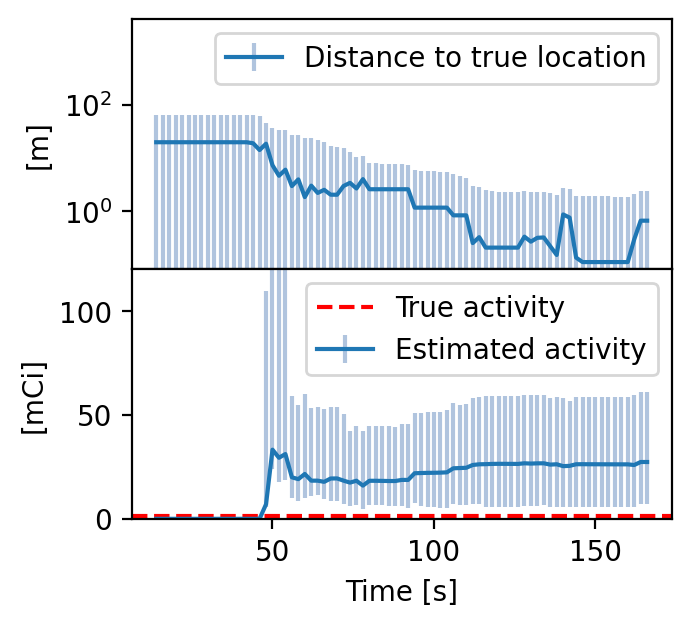

In [7]:
with open("sim_dip.pickle", "rb") as handle:
    (
        estimation_errors,
        true_voxel_zscores,
        spread_sigmas,
        fit_activity,
        times,
    ) = pickle.load(handle)

fit_activity = np.array(fit_activity)
act_mean = fit_activity[:, 0]
act_low = fit_activity[:, 1]
act_high = fit_activity[:, 2]

selection = (spread_sigmas != 100) & (spread_sigmas != -1)
times_cut = times[selection]
spread_cut = spread_sigmas[selection]

sel_fit = act_mean != -1
act_cut = act_mean[sel_fit]
act_low_cut = act_low[sel_fit]
act_high_cut = act_high[sel_fit]

times_act = times[sel_fit]

sel_est = estimation_errors > 0
est_cut = estimation_errors[sel_est]
time_est = times[sel_est]

fig, ax = plt.subplots(2, 1, dpi=200, figsize=((2.7, 2.5)), sharex=True)
fig.subplots_adjust(0, 0, 1, 1, 0, 0)
ax[0].errorbar(
    times_cut,
    est_cut,
    yerr=spread_cut,
    label="Distance to true location",
    ecolor="lightsteelblue",
)
ax[0].legend()
ax[0].set_ylabel("[m]")
ax[0].set_yscale("log")
ax[0].set_ylim([None, 4000])


mili = 1000
ax[1].errorbar(
    times_act,
    act_cut / mili,
    yerr=(act_low_cut / mili, act_high_cut / mili),
    label="Estimated activity",
    ecolor="lightsteelblue",
)
low, high = ax[1].get_ylim()
ax[1].set_ylim([low, high * 1.2])
ax[1].set_ylim([-300 / mili, 120000 / mili])
ax[1].axhline(1200 / mili, ls="--", c="r", label="True activity")
ax[1].legend(loc=1)
ax[1].set_ylabel("[mCi]")


# ax[2].plot(time_est, est_cut, label='Distance to true location')
# ax[2].legend()

ax[1].set_xlabel("Time [s]")

# for axx in ax:
#     axx.axvspan(51, 57, color='C2', alpha=0.2, zorder=-1, linewidth=0, label='Takeoff /\nland')
#     axx.axvspan(57, 76, color='C0', alpha=0.2, zorder=-1, linewidth=0, label='Grid flight')
#     axx.axvspan(76, 112, color='C4', alpha=0.2, zorder=-1, linewidth=0, label='Go above\nsource')


#     axx.axvspan(112, 147, color='C1', alpha=0.2, zorder=-1, linewidth=0, label='Down and\ncross')
#     axx.axvspan(147, 164, color='C4', alpha=0.2, zorder=-1, linewidth=0)

#     axx.axvspan(164, 200, color='C1', alpha=0.2, zorder=-1, linewidth=0)
#     axx.axvspan(200, 280, color='C0', alpha=0.2, zorder=-1, linewidth=0)
#     axx.axvspan(280, 300, color='C2', alpha=0.2, zorder=-1, linewidth=0)

In [12]:
fit_activity[:, 0][-1]

1775.8634357036237

In [8]:
with open("experiment.pickle", "rb") as handle:
    (
        estimation_errors,
        true_voxel_zscores,
        spread_sigmas,
        fit_activity,
        times,
    ) = pickle.load(handle)

fit_activity = np.array(fit_activity)
act_mean = fit_activity[:, 0]
act_low = fit_activity[:, 1]
act_high = fit_activity[:, 2]

selection = (spread_sigmas != 100) & (spread_sigmas != -1)
times_cut = times[selection]
spread_cut = spread_sigmas[selection]

sel_fit = act_mean != -1
act_cut = act_mean[sel_fit]
act_low_cut = act_low[sel_fit]
act_high_cut = act_high[sel_fit]

times_act = times[sel_fit]

sel_est = estimation_errors > 0
est_cut = estimation_errors[sel_est]
time_est = times[sel_est]

fig, ax = plt.subplots(2, 1, dpi=200, figsize=((2.7, 2.5)), sharex=True)
fig.subplots_adjust(0, 0, 1, 1, 0, 0)
ax[0].errorbar(
    times_cut,
    est_cut,
    yerr=spread_cut,
    label="Distance to true location",
    ecolor="lightsteelblue",
)
ax[0].legend()
ax[0].set_ylabel("[m]")
ax[0].set_ylim([None, 80])

mili = 1000
ax[1].errorbar(
    times_act,
    act_cut / mili,
    yerr=(act_low_cut / mili, act_high_cut / mili),
    label="Estimated activity",
    ecolor="lightsteelblue",
)
low, high = ax[1].get_ylim()
ax[1].set_ylim([low, high * 1.2])
ax[1].set_ylim([-300 / mili, 12000 / mili])
ax[1].axhline(1400 / mili, ls="--", c="r", label="True activity")
ax[1].legend(loc=1)
ax[1].set_ylabel("[mCi]")


# ax[2].plot(time_est, est_cut, label='Distance to true location')
# ax[2].legend()

ax[1].set_xlabel("Time [s]")

for axx in ax:
    axx.axvspan(
        51, 57, color="C2", alpha=0.2, zorder=-1, linewidth=0, label="Takeoff /\nland"
    )
    axx.axvspan(
        57, 76, color="C0", alpha=0.2, zorder=-1, linewidth=0, label="Grid flight"
    )
    axx.axvspan(
        76, 112, color="C4", alpha=0.2, zorder=-1, linewidth=0, label="Go above\nsource"
    )

    axx.axvspan(
        112, 147, color="C1", alpha=0.2, zorder=-1, linewidth=0, label="Down and\ncross"
    )
    axx.axvspan(147, 164, color="C4", alpha=0.2, zorder=-1, linewidth=0)

    axx.axvspan(164, 200, color="C1", alpha=0.2, zorder=-1, linewidth=0)
    axx.axvspan(200, 280, color="C0", alpha=0.2, zorder=-1, linewidth=0)
    axx.axvspan(280, 300, color="C2", alpha=0.2, zorder=-1, linewidth=0)

# Under here takes longer

In [63]:
# Make one frame
f = files[0]
f = h5_file
recon_config.set_param("E", 662.0)
recon_config.set_param("path_padding", 30)
recon_config.set_param("voxel_size", 0.1)
traj, rad = h5_to_traj(f)
trajcut = traj.cut(
    ranges={"ts": [traj.ts[0], traj.ts[0] + 1000], "px": [-100, 100], "py": [-100, 100]}
)
if type(trajcut) == tr.trajectory.Trajectories:
    trajcut = trajcut[1]
world = create_world(trajcut)
meas = mfdf.Measurement(rad, trajcut, world, sys_config)
fix_header(meas)
times = np.arange(8, meas.traj.duration, 4)
times = np.arange(90, 120, 1)
# times = [20]
est_error, true_zscore, times = recon_in_time_steps(meas, times)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [113]:
est_error2 = est_error.copy()
true_zscore2 = true_zscore.copy()

NameError: name 'times' is not defined

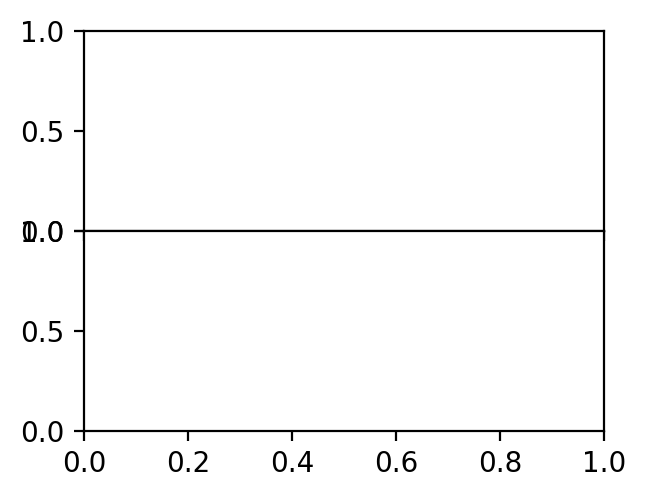

In [625]:
fig, ax = plt.subplots(2, 1, dpi=200, figsize=((2.6, 2)), sharex=True)
fig.subplots_adjust(0, 0, 1, 1, 0, 0)
est2 = est_error[est_error != -1]
ax[0].semilogy(times[-len(est2) :], est2, label="20 MLEM \niterations", lw=3)
ax[1].plot(times, true_zscore, lw=3)
est2 = est_error2[est_error != -1]
ax[0].semilogy(times[-len(est2) :], est2, label="10 MLEM \niterations", ls="-")
ax[1].plot(times, true_zscore2)

ax[1].set_xlabel("Time [s]")
ax[0].set_ylabel("Estimation \ndeviation [m]")
ax[1].set_ylabel("True location\n z-score")

# ax[2].plot(meas.traj.ts - meas.traj.ts[0], meas.traj.pz)

for axx in ax:
    axx.axvspan(
        51, 57, color="C2", alpha=0.2, zorder=-1, linewidth=0, label="Takeoff /\nland"
    )
    axx.axvspan(
        57, 76, color="C0", alpha=0.2, zorder=-1, linewidth=0, label="Grid flight"
    )
    axx.axvspan(
        76, 112, color="C4", alpha=0.2, zorder=-1, linewidth=0, label="Go above\nsource"
    )

    axx.axvspan(
        112, 147, color="C1", alpha=0.2, zorder=-1, linewidth=0, label="Down and\ncross"
    )
    axx.axvspan(147, 164, color="C4", alpha=0.2, zorder=-1, linewidth=0)

    axx.axvspan(164, 200, color="C1", alpha=0.2, zorder=-1, linewidth=0)
    axx.axvspan(200, 280, color="C0", alpha=0.2, zorder=-1, linewidth=0)
    axx.axvspan(280, 300, color="C2", alpha=0.2, zorder=-1, linewidth=0)


ax[0].legend(loc="center left", bbox_to_anchor=(1, 0.0))

# for axx in ax:
#     axx.axvline(51, color='grey', linestyle='--')
#     axx.axvline(112, color='grey', linestyle='--')
#     axx.axvline(164, color='grey', linestyle='--')

In [ ]:
make_gif("20_iterations_30padding")